In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


In [2]:
training_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")


In [3]:
training_data["outcome"].replace("euthanized", "died", inplace=True)


In [4]:
X = training_data.drop(columns=["outcome"])
y = training_data["outcome"]

In [5]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

object_column_X = X.select_dtypes(include=['object'])

for column in object_column_X:
    X[column] = label_encoder.fit_transform(X[column])
    

In [6]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size= 0.2, random_state=42)


In [8]:
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],            # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.1, 0.2],         # Learning rate (step size shrinkage)
    'max_depth': [3, 4, 5],                   # Maximum depth of each tree
    'gamma': [0, 0.1, 0.2],                   # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0, 0.01, 0.1],              # L1 regularization term on weights
    'scale_pos_weight': [1, 2, 3],            # Controls the balance of positive and negative weights
    'random_state': [42]                      # Seed for random number generation (for reproducibility)
}

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, verbose=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 1/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, reg_alpha=0, scale_pos_weight=1;, score=0.792 total time=   1.0s
[CV 2/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, reg_alpha=0, scale_pos_weight=1;, score=0.693 total time=   0.4s
[CV 3/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, reg_alpha=0, scale_pos_weight=1;, score=0.701 total time=   0.5s
[CV 4/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, reg_alpha=0, scale_pos_weight=1;, score=0.706 total time=   0.2s
[CV 5/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, reg_alpha=0, scale_pos_weight=1;, score=0.716 total time=   0.7s
[CV 1/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, reg_alpha=0, scale_pos_weight=2;, score=0.693 total time=   0.2s
[CV 2/

In [9]:
best_xgb_classifier = xgb.XGBClassifier(**best_params)

best_xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [11]:
y_pred = best_xgb_classifier.predict(X_test)

y_pred[:10]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1])

In [12]:
# Calculate f-1 score
f1 = f1_score(y_test, y_pred, average='micro')
print("F1 Score:", f1)


F1 Score: 0.7849056603773585


In [13]:
from sklearn.metrics import precision_score, recall_score

# Assuming you have true labels (y_test) and predicted labels (y_pred)
# Calculate precision
precision = precision_score(y_test, y_pred, average='micro')

# Calculate recall
recall = recall_score(y_test, y_pred, average='micro')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Precision: 0.78
Recall: 0.78


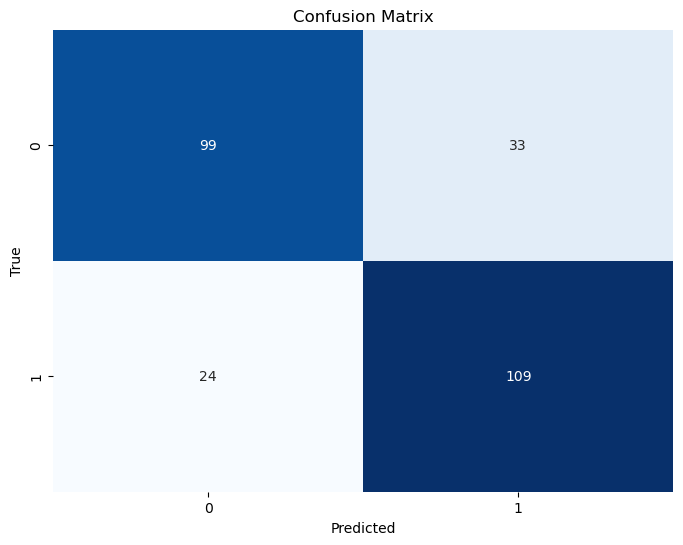

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_test) and predicted labels (y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Assuming you have true labels (y_test) and predicted labels (y_pred)
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.80      0.75      0.78       132
           1       0.77      0.82      0.79       133

    accuracy                           0.78       265
   macro avg       0.79      0.78      0.78       265
weighted avg       0.79      0.78      0.78       265



In [16]:
#save the model
import joblib

# Save the trained model to a file
joblib.dump(best_xgb_classifier, 'xgb_model_train_data.pkl')

['xgb_model_train_data.pkl']

In [17]:
loaded_model = joblib.load('xgb_model_train_data.pkl')


In [19]:
object_columns_test = test_data.select_dtypes(include=['object'])

# Iterate through categorical columns and encode them
for column in object_columns_test:
    test_data[column] = label_encoder.fit_transform(test_data[column])


In [20]:
test_predictions = loaded_model.predict(test_data)

test_predictions

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,

In [21]:
#make dataframe of predictions
submission_df = pd.DataFrame({'id': test_data['id'],
                           'outcome': test_predictions})

submission_df.head()

,id,outcome
0,1235,1
1,1236,0
2,1237,1
3,1238,0
4,1239,1


In [22]:
# undo encoding
submission_df['outcome'] = submission_df['outcome'].replace({1: 'lived',
                                                             0: 'died'})

print(len(submission_df))
submission_df.head()

824


,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,died
4,1239,lived


In [23]:
submission_df.to_csv("data/submission_xgb_train_data.csv", index=False)


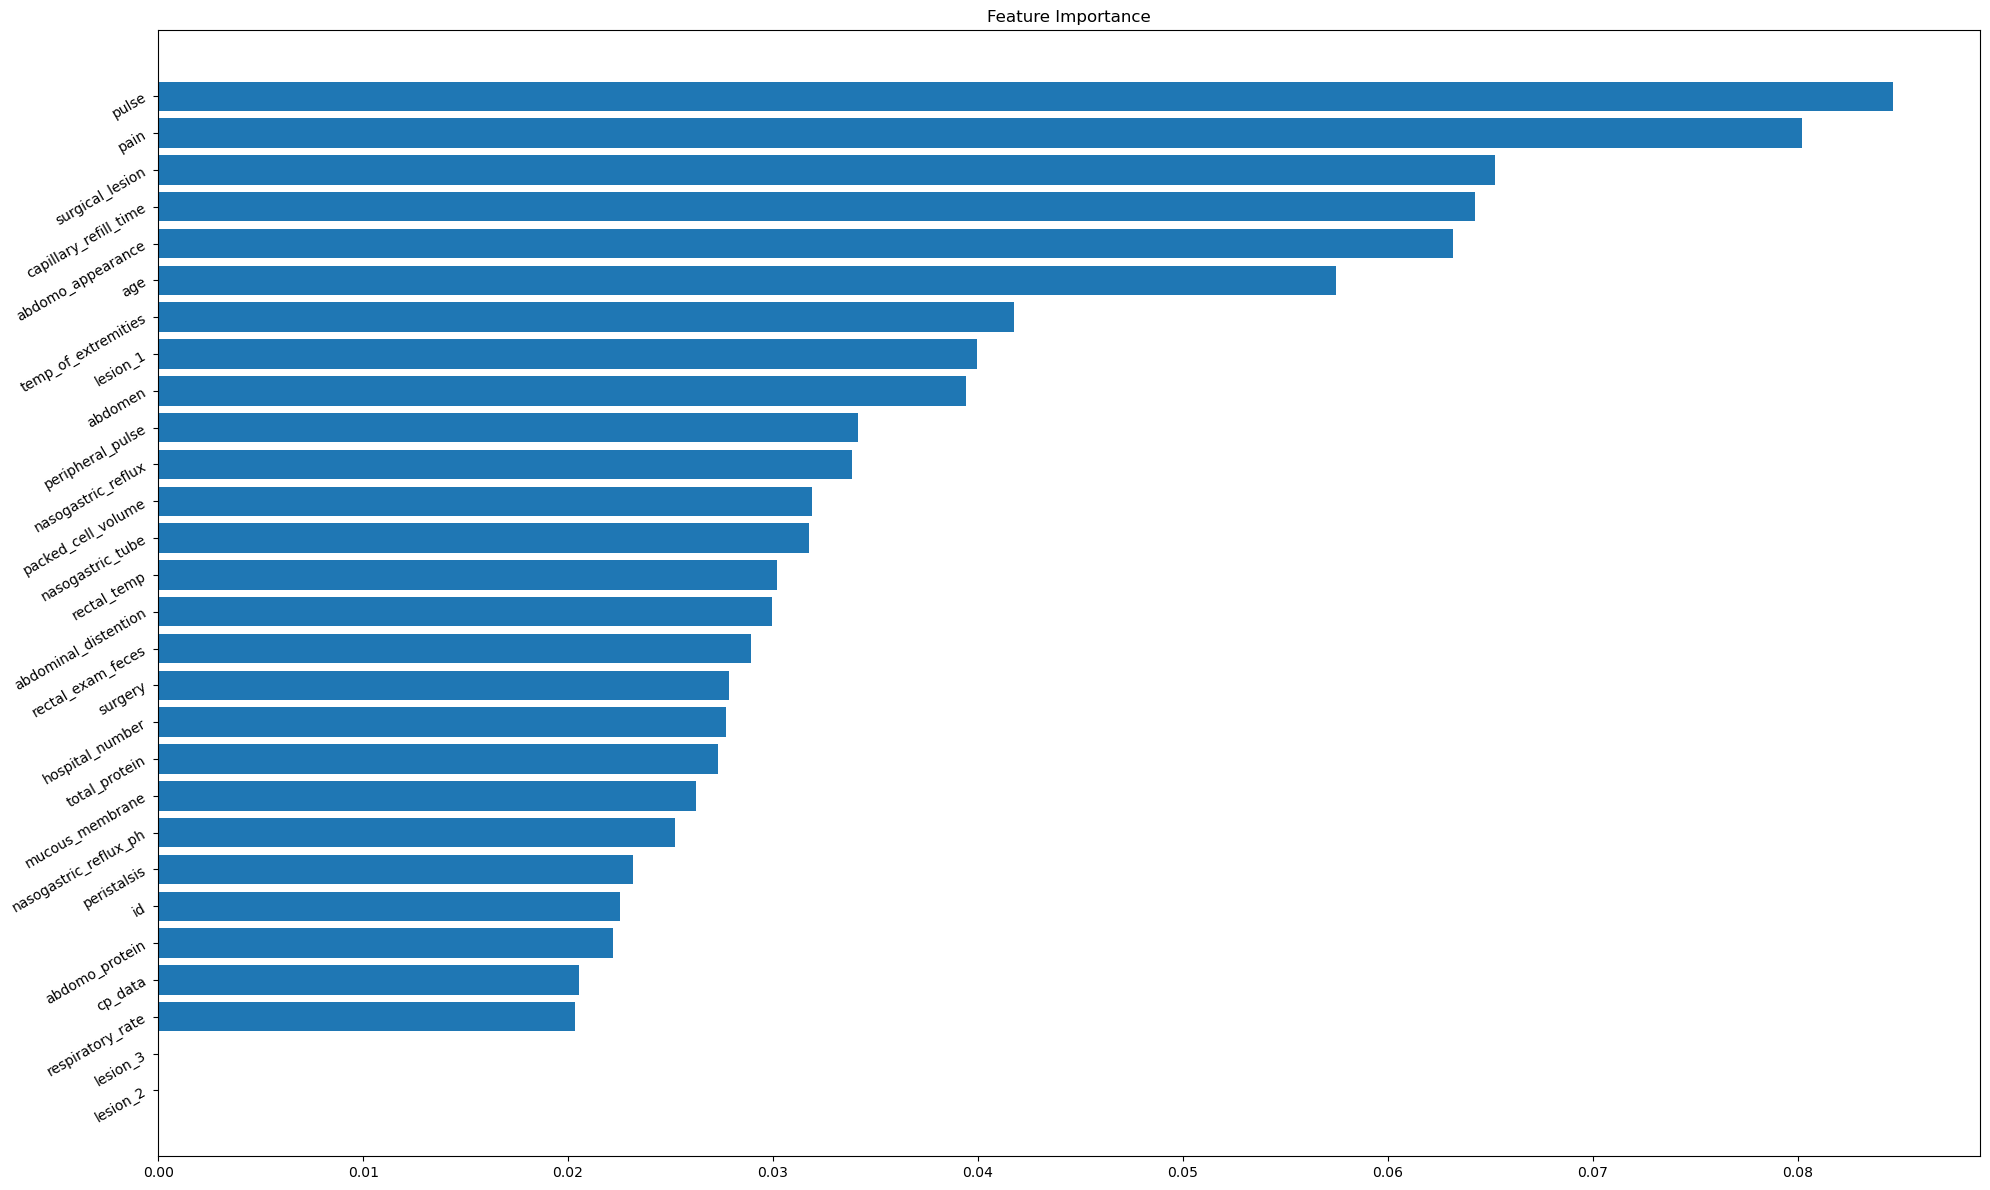

In [24]:
feature_importance = best_xgb_classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig, ax = plt.subplots(figsize=(20, 12))

# Use the column names from X_train as feature labels
ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(X_train.columns[sorted_idx], rotation=30)  # Rotate labels to 0 degrees
ax.set_title('Feature Importance')

plt.tight_layout()
plt.show()
